In [1]:
from bs4 import BeautifulSoup
import requests
import re
import matplotlib.pylab as plt
import matplotlib.image as mping
import os
import pandas as pd
import numpy as np
import collections
import seaborn as sns
import multiprocessing
import cv2
from keras.utils import to_categorical
print(multiprocessing.cpu_count())
# Imports keras
import keras
from keras.layers import Conv2D, MaxPooling2D, Dense, Input, Flatten, Dropout, UpSampling2D, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
%matplotlib inline

from keras.applications import resnet50

Using TensorFlow backend.


32


In [2]:
def resize2(im,desired_size=250):
    old_size = im.shape[:2] 
    ratio = float(desired_size)/min(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im2 = cv2.resize(im, (new_size[1], new_size[0]))
    if im2.shape[0]>250:
        mid=int(im2.shape[0]/2)
        lt=mid-125
        rt=mid+125
        im3=im2[lt:rt,:,:]
    else:
        mid=int(im2.shape[1]/2)
        lt=mid-125
        rt=mid+125
        im3=im2[:,lt:rt,:]
    im4=cv2.resize(im3,(250,250))/255
    return im4

In [3]:
def resize3(im,desired_size=250):
    old_size = im.shape[:2] 
    idx = np.argmax(old_size)
    new_size = np.zeros(2)
    new_size[0] = int((desired_size*old_size[0])/old_size[idx])
    new_size[1] = int((desired_size*old_size[1])//old_size[idx])
    new_size[idx] = int(desired_size)
    im2 = cv2.resize(im, (int(new_size[1]), int(new_size[0])))
    if im2.shape[0]<desired_size:
        im3 = np.zeros((desired_size,desired_size,im2.shape[-1]))
        im3[:im2.shape[0],:,:]=im2
    else:
        im3 = np.zeros((desired_size,desired_size,im2.shape[-1]))
        im3[:,:im2.shape[1],:]=im2[:,:,:]
    return im3[:,:,:3].astype('int')

In [4]:
count = 0
img_all = []
width_tot=[]
height_tot=[]
for h,_,fs in os.walk('Images/'):
    for f in fs:
        if f.endswith('.jpg'):
            img = mping.imread(h+'/'+f)
            img_all.append(img)
    count += 1
    print(count)
    if count>5:
        break
    

1
2
3
4
5
6


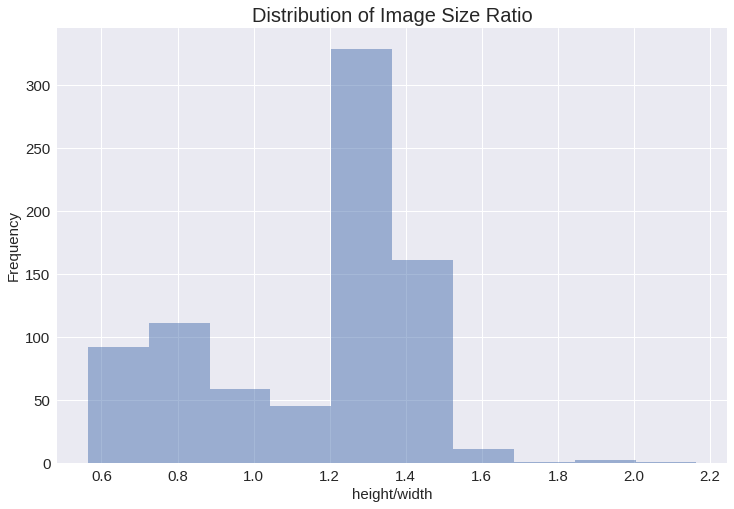

In [5]:
ratio_tot=[]
for im in img_all:
    width, height, depth = im.shape
    ratio = height/width
    ratio_tot.append(ratio)
    
plt.figure(figsize=(12,8))
plt.hist(ratio_tot, alpha =0.5)
#plt.hist(height_tot, alpha =0.5, label= "height")
plt.xlabel("height/width", size =15)
plt.ylabel("Frequency", size =15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.title("Distribution of Image Size Ratio", fontsize =20)
#plt.legend(prop={'size':15})
plt.savefig('distribution_size.png')

In [6]:
# Scrape information from AKC website
page = requests.get('https://www.akc.org/dog-breeds/sporting/page/3')
soup = BeautifulSoup(page.content,'html.parser')
name_links = soup.select_one('select."custom-select__select"').select('option')[1:]
group_map = {}
for p in name_links:
    link = p.get('value')
    l_soup = BeautifulSoup(requests.get(link).content,'html.parser')
    group_map[p.text.lower()]=l_soup.select_one('li > span > a').text

In [7]:
# Classify and correct every groups
cls = !ls Images/
cls = [c.split('-')[1].replace('_',' ') for c in cls]
groups1 = {}
groups2 = {}
first_word = [re.split(' |-',c)[0] for c in group_map.keys()]
count1 = 0
count2 = 0
for c in cls:
    if c.lower() in group_map.keys():
        groups1[c.lower()] = group_map[c.lower()]
    elif c.split(' ')[0].lower() in first_word:
        idx = first_word.index(c.split(' ')[0].lower())
        groups2[c.lower()] = list(group_map.values())[idx]
        count1 += 1
    else:
        print(c)
        count2 += 1
groups3 = {}
groups3['pekinese'] = 'Toy Group'
groups3['leonberg'] = 'Working Group'
groups3['african hunting dog'] = 'NAN' # Not sure about this one, suspect it is Basenji Dog
groups3['blenheim spaniel'] = 'Toy Group' # Also known as Cavalier King Charles Spaniel
groups3['walker hound'] = 'Hound Group' # Full name is Treeing Walker Coonhound
groups3['scotch terrier'] = 'Terrier Group' # aka Scottish Terrier
groups3['groenendael'] = 'Herding Group' # A branch of Belgian Sheepdog
groups3['malinois'] = 'Herding Group' # Formally as Belgian Malinois
groups3['kelpie'] = 'Foundation Stock Service' # Formally as Australian Kelpie
groups3['eskimo dog'] = 'Non-Sporting Group' # Formally as American Eskimo Dog
groups3['malamute'] = 'Working Group' # Formally as Alaskan Malamute
groups3['brabancon griffon'] = 'Hybrid' # Brabancon and Brussels Griffon hybrid
groups3['mexican hairless'] = 'Non-Sporting Group' # Formally as Xoloitzcuintli
groups3['dingo'] = 'NAN' # Originally considered as wolf, now believed to be a independent branch
groups3['dhole'] = 'NAN' # ALso close to wolf, not clear which superclass it belongs to
# groups2['Boston bull'] is the only one in American Kennel website starting with Boston, assume it's the one
# groups2['English springer'] is labeled correctly for the wrong reason
groups2['german shepherd'] = 'Herding Group'
groups2['german short'] = 'Sporting Group'
groups2['basset'] = 'Hound Group'
groups2['bull mastiff'] = 'Working Group'
groups2['miniature poodle'] = 'Non-Sporting Group'
groups2['standard poodle'] = 'Non-Sporting Group'
groups2['toy poodle'] = 'Non-Sporting Group' # Assuming that toy poodle is a kind of poodle anyways
# groups2['wire'] is wire-haired fox terrier, assume it's the same as wire fox terrier, though there is a group of wirehaired
groups = {**groups1,**groups2,**groups3}

Pekinese
Blenheim spaniel
Walker hound
Scotch terrier
groenendael
malinois
kelpie
Eskimo dog
malamute
Leonberg
Brabancon griffon
Mexican hairless
dingo
dhole
African hunting dog


In [12]:
# Generate train and test set, SET the first two lines
no_train = 3
no_test = 0
data_train = []
data_test = []
cat = 0
for h,_,fs in os.walk('/n/home03/xwei/Desktop/Images/'):
    count = 0
    for f in fs:
        if f.endswith('.jpg'):
            img = mping.imread(h+'/'+f)
            count += 1
            meta = []
            with open((h+'/'+f).replace('Images','Annotation').replace('.jpg',''),'r') as fp:
                print((h))
                soup = BeautifulSoup(fp.read(),'html.parser')
                xmin = int(soup.select_one('xmin').text)
                xmax = int(soup.select_one('xmax').text)
                ymin = int(soup.select_one('ymin').text)
                ymax = int(soup.select_one('ymax').text)
                img = img[ymin:ymax,xmin:xmax,:]
            meta.append(resize3(img,64))
            meta.append(h.split('/')[-1].split('-')[1].replace('_',' ').lower())
            meta.append(groups[h.split('/')[-1].split('-')[1].replace('_',' ').lower()])
            if count <= no_train:
                data_train.append(meta)
            elif count <= no_train + no_test:
                data_test.append(meta)
            else:
                break
    cat += 1
#     if cat == 3:
#         break

/n/home03/xwei/Desktop/Images/n02107574-Greater_Swiss_Mountain_dog
/n/home03/xwei/Desktop/Images/n02107574-Greater_Swiss_Mountain_dog
/n/home03/xwei/Desktop/Images/n02107574-Greater_Swiss_Mountain_dog
/n/home03/xwei/Desktop/Images/n02107574-Greater_Swiss_Mountain_dog
/n/home03/xwei/Desktop/Images/n02100236-German_short-haired_pointer
/n/home03/xwei/Desktop/Images/n02100236-German_short-haired_pointer
/n/home03/xwei/Desktop/Images/n02100236-German_short-haired_pointer
/n/home03/xwei/Desktop/Images/n02100236-German_short-haired_pointer
/n/home03/xwei/Desktop/Images/n02088632-bluetick
/n/home03/xwei/Desktop/Images/n02088632-bluetick
/n/home03/xwei/Desktop/Images/n02088632-bluetick
/n/home03/xwei/Desktop/Images/n02088632-bluetick
/n/home03/xwei/Desktop/Images/n02106550-Rottweiler
/n/home03/xwei/Desktop/Images/n02106550-Rottweiler
/n/home03/xwei/Desktop/Images/n02106550-Rottweiler
/n/home03/xwei/Desktop/Images/n02106550-Rottweiler
/n/home03/xwei/Desktop/Images/n02105641-Old_English_sheepdog

In [9]:
meta

[array([[[ 70,  38,  25],
         [ 74,  42,  29],
         [ 69,  37,  24],
         ..., 
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[ 72,  42,  28],
         [ 73,  41,  28],
         [ 67,  34,  25],
         ..., 
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[ 68,  38,  24],
         [ 73,  41,  28],
         [ 65,  32,  23],
         ..., 
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        ..., 
        [[ 60,  61,  52],
         [ 68,  70,  59],
         [ 66,  68,  57],
         ..., 
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[ 83,  85,  80],
         [ 86,  89,  88],
         [ 87,  91,  89],
         ..., 
         [  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0]],
 
        [[134, 138, 143],
         [135, 140, 145],
         [137, 142, 147],
         ..., 
         [  0,   0,   0

In [11]:
X_train = np.array([m[0] for m in data_train])
y_train = [m[2] for m in data_train]
group2num = {'Working Group':0,'Sporting Group':1,'Hound Group':2,'Herding Group':3,
             'Toy Group':4,'Terrier Group':5,'Non-Sporting Group':6,'Foundation Stock Service':7,'Hybrid':7,'NAN':7}
y_train = np.array(to_categorical([group2num[y] for y in y_train],8))

In [32]:
# Building a simple CNN
cnn_md1 = Sequential([
    Conv2D(32,kernel_size=(7,7),padding='same',activation='relu',use_bias=True,kernel_initializer='normal',input_shape=(64,64,3,)),
    Conv2D(32,kernel_size=(7,7),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    MaxPooling2D(strides=(2,2)),
    Conv2D(64,kernel_size=(5,5),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    Conv2D(64,kernel_size=(5,5),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    MaxPooling2D(strides=(2,2)),
    Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    Conv2D(128,kernel_size=(3,3),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    MaxPooling2D(strides=(2,2)),
    Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    Conv2D(256,kernel_size=(3,3),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    MaxPooling2D(strides=(2,2)),
    Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    Conv2D(512,kernel_size=(3,3),padding='same',activation='relu',use_bias=True,kernel_initializer='normal'),
    MaxPooling2D(strides=(2,2)),
    Flatten(),
    Dense(512,activation='relu'),
    Dense(8,activation='softmax')
])
cnn_md1.compile('adam','categorical_crossentropy',['acc'])

In [15]:
history1 = cnn_md1.fit(X_train,y_train,batch_size=32,epochs=15,validation_split=0.2)

Train on 288 samples, validate on 72 samples
Epoch 1/15
288/288 [==============================] - 43s 149ms/step - loss: 14.1552 - acc: 0.1215 - val_loss: 14.1033 - val_acc: 0.1250
Epoch 2/15
288/288 [==============================] - 42s 146ms/step - loss: 13.4317 - acc: 0.1667 - val_loss: 14.1033 - val_acc: 0.1250

In [ ]:
# ann_md2 = Sequential([
#     Dense(128,input_shape=(250,250,3,),activation='relu'),
#     Flatten(),
#     Dense(128,activation='relu'),
#     Dense(8,activation='softmax')
# ])
# ann_md2.compile('sgd','categorical_crossentropy',['acc'])
# history2 = ann_md2.fit(X_train,y_train,batch_size=1,epochs=15,validation_split=0.2)

In [20]:
X_train_scaled = X_train.copy()
for i in range(3):
    X_train_scaled[:,:,:,i] = (X_train[:,:,:,i]-np.mean(X_train[:,:,:,i]))/np.std(X_train[:,:,:,i])

In [33]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
datagen.fit(X_train)
cnn_md1.fit_generator(datagen.flow(X_train_scaled, y_train, batch_size=32),
                    steps_per_epoch=len(X_train_scaled) / 32, epochs=15)

Epoch 1/15
12/11 [================================] - 51s 4s/step - loss: 13.6033 - acc: 0.1558
Epoch 2/15
12/11 [======================

In [13]:
# key is breed name and value is list containing the 10 images this is the same thing above, 
#we accidentally had 2 group members do the same thing which was making a dictionary of values of breed to breed class
file_type=pd.read_csv('file',header=None,names=['filename','type'])

file_type['annotations']=['Annotation/'+i.replace('.jpg','') for i in file_type.filename.values]
file_type['breed']=[i.split('/')[0].split('-')[1] for i in file_type.filename.values]
a_ = np.zeros((file_type.filename.values.shape[0],4))
a_.shape

for index,row in file_type.iterrows():
    with open(row['annotations'],'r') as fp:
                soup = BeautifulSoup(fp.read(),'html.parser')
                xmin = int(soup.select_one('xmin').text)
                xmax = int(soup.select_one('xmax').text)
                ymin = int(soup.select_one('ymin').text)
                ymax = int(soup.select_one('ymax').text)
                img = [ymin,ymax,xmin,xmax]
                a_[index,:]=img

file_type=pd.concat([file_type,pd.DataFrame(a_,columns=['ymin','ymax','xmin','xmax'])],axis=1)

(20580, 4)

In [29]:
breeds_10=list()
class_dictionary={}
for i in range(1,121):
    breed=dict()
    breed['breed']=file_type['breed'].loc[file_type.type==i].values[0]
    breed['type_num']=i
    breed['breed_class']=groups[breed['breed'].lower().replace('_',' ')]
    class_dictionary[file_type['breed'].loc[file_type.type==i].values[0]]=breed['breed_class']
    
    for index, row in file_type.loc[file_type.type==i].iterrows():
        if index>9: 
            break
        else: continue
    breeds_10.append(breed)
file_type['breed_class']=[groups[i.lower().replace('_',' ')] for i in file_type.breed.values]
yy=file_type['breed'].value_counts()
file_type.head()

KeyboardInterrupt: 

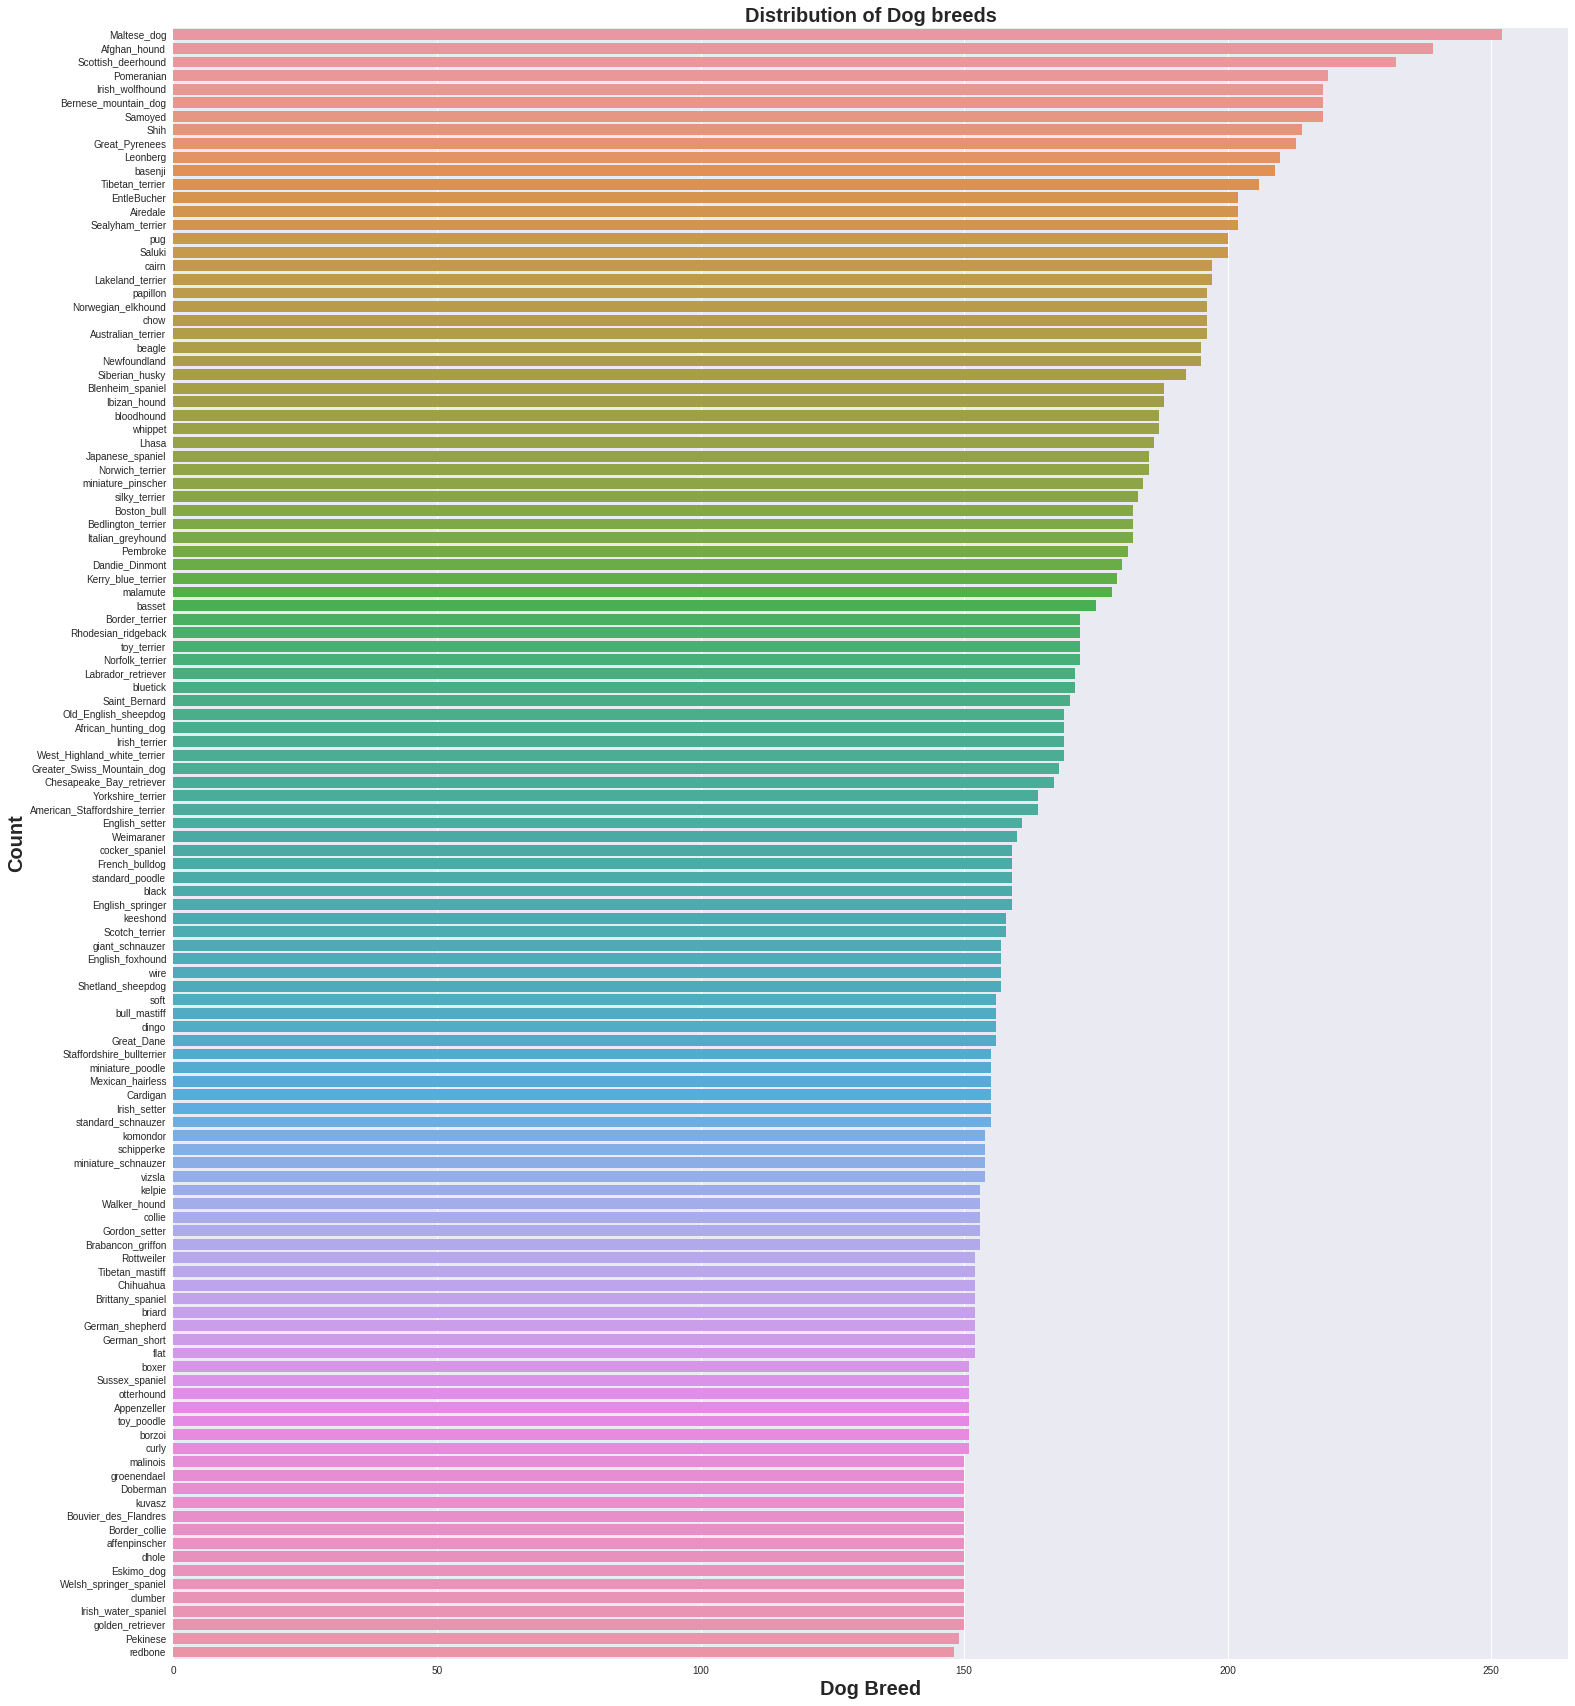

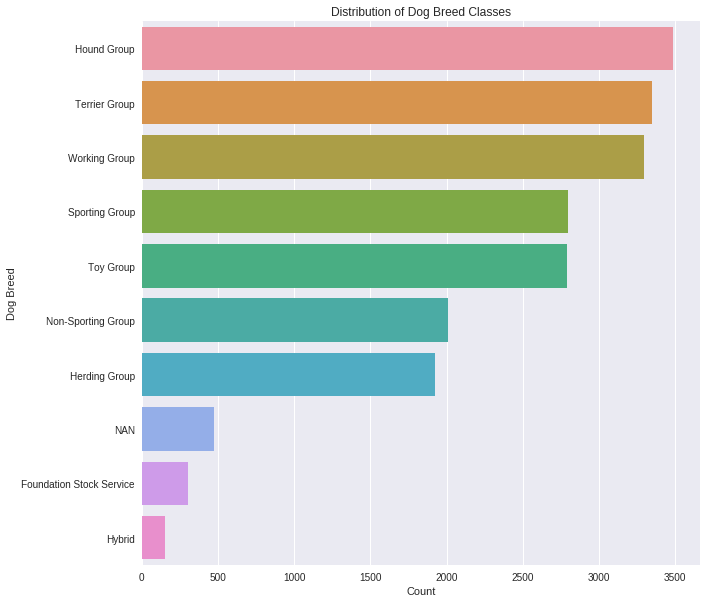

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 30)
sns.set()
ax = sns.barplot(y = yy.index, x = yy, data = file_type,orient='h')
#ax.set_xticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 8)
ax.set_xlabel('Dog Breed',fontsize=20,fontweight='bold')
ax.set_ylabel('Count',fontsize=20,fontweight='bold')
ax.set_title('Distribution of Dog breeds',fontsize=20,fontweight='bold')
plt.savefig('distribution_breeds.png')
yy=file_type['breed_class'].value_counts()

fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.set()
ax = sns.barplot(y = yy.index, x = yy, data = file_type,orient='h')
#ax.set_xticklabels(ax.get_yticklabels(), rotation = 90, fontsize = 8)
ax.set(ylabel='Dog Breed', xlabel='Count')
ax.set_title('Distribution of Dog Breed Classes')
plt.savefig('distribution_class.png',fontsize=20)

In [15]:
file_type

NameError: name 'file_type' is not defined

In [23]:
file_type.head()

,filename,type,breed,breed_class
0,n02085620-Chihuahua/n02085620_10074.jpg,1,Chihuahua,Toy Group
1,n02085620-Chihuahua/n02085620_10131.jpg,1,Chihuahua,Toy Group
2,n02085620-Chihuahua/n02085620_10621.jpg,1,Chihuahua,Toy Group
3,n02085620-Chihuahua/n02085620_1073.jpg,1,Chihuahua,Toy Group
4,n02085620-Chihuahua/n02085620_10976.jpg,1,Chihuahua,Toy Group


In [41]:
resnet_md = ResNet50(input_shape=(64,64,3,),classes=8,include_top=True,weights=None)
resnet_md.compile('adam','categorical_crossentropy',['acc'])
history3 = resnet_md.fit(X_train_scaled,y_train,batch_size=24,epochs=15,validation_split=0.2)

ValueError: Input size must be at least 197x197; got `input_shape=(64, 64, 3)`

In [1]:
!ls

Annotation		 docs		milestone_3.ipynb
annotation.tar		 EDA.ipynb	README.md
_config.yml		 file		test_list.mat
distribution_breeds.png  file_list.mat	train_list.mat
distribution_class.png	 Icon?
distribution_size.png	 Images
